# Preparing the Data : SFO to PHL

In [1]:
import pandas as pd
import networkx as nx

# helper functions
import data_cleaner as dc
import graph_functions as gf

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [2]:
# read data and filter for relevant delayed flights
jan_df = dc.filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = dc.filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = dc.filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = dc.filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = dc.filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = dc.filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = dc.filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = dc.filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = dc.filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = dc.filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = dc.filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = dc.filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

# change delay information to binary
delay_li = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
for delay in delay_li:
    flights_df = dc.changeDelaytoBinary(flights_df, delay)

# for DEP_DELAY, we'd like three variables: -1 (early departure), 0 (regular), 1 (late departure)
mask = flights_df['DEP_DELAY'] > 0.0
flights_df.loc[mask, 'DEP_DELAY'] = 1

mask = flights_df['DEP_DELAY'] < 0.0
flights_df.loc[mask,'DEP_DELAY'] = -1

# TAXI_IN, TAXI_OUT: in 15-minute increments
# 0: less than 15, 1: less than 30, ...
flights_df['TAXI_IN'] = flights_df['TAXI_IN'] // 15
flights_df['TAXI_OUT'] = flights_df['TAXI_OUT'] // 15

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [3]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
airports_df = dc.dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df in intervals of 10
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures'] // 10
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures'] // 10
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals'] // 10
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals'] // 10
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

# change all times to binary variable AM (0) or PM (1)
CRS_time_li = ['CRS_DEP_TIME', 'CRS_ARR_TIME']
for CRS_time in CRS_time_li:
    flights_df = dc.changeTimetoBinary(flights_df, CRS_time)

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [4]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df = flights_df.astype('int')
# save as CSV
flights_df.to_csv('full_data.csv',index=False)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
MONTH,1,1,1,1,1,1,1,1,1,1,...,12,12,12,12,12,12,12,12,12,12
DAY_OF_WEEK,3,6,4,6,7,1,2,4,5,4,...,4,4,3,2,1,2,1,7,5,4
CRS_DEP_TIME,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,1,1,0,1
DEP_DELAY,1,1,1,1,-1,0,-1,1,1,1,...,1,1,-1,-1,1,1,-1,0,1,0
TAXI_OUT,1,0,1,1,1,1,1,1,1,2,...,1,1,2,2,3,1,1,1,1,1
TAXI_IN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CRS_ARR_TIME,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,0,0,1,0
ARR_DEL15,0,1,0,0,1,0,0,1,0,1,...,1,1,1,0,1,0,0,0,1,1
CARRIER_DELAY,0,1,0,0,0,0,0,1,0,1,...,1,1,0,0,1,0,0,0,1,0
WEATHER_DELAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [5]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)
# save as CSV
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [6]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

### ARR_DEL15

In [7]:
arr_15_from = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'DelayedDepartureSFO', 'ScheduledDepartureSFO']
gf.regression_model(train_df, arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     952.1
Date:                Sun, 06 May 2018   Prob (F-statistic):               0.00
Time:                        20:34:50   Log-Likelihood:                 20.897
No. Observations:                 774   AIC:                            -27.79
Df Residuals:                     767   BIC:                             4.768
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CRS_DEP_TIME              0.0906      0.016      5.747      0.000       0.060       0.122
CRS_ARR_TIME              0.1126      0.014      8.308      0.000       0.086       0.139
CARRIER_DELAY             0.4003      0.021     19.041      0.000       0.359       0.442
NAS_DELAY                 0.6582      0.018     37.573      0.000       0.624       0.693
LATE_AIRCRAFT_DELAY       0.3651      0.022     16.391      0.000       0.321       0.409
DelayedDepartureSFO       0.1117      0.037      3.046      0.002       0.040       0.184
ScheduledDepartureSFO    -0.0099      0.006     -1.559      0.119      -0.022       0.003
==============================================================================
Omnibus:                       39.280   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.094
Skew:                           0.554   Prob(JB):                     2.66e-10
Kurtosis:                       3.373   Cond. No.                         7.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


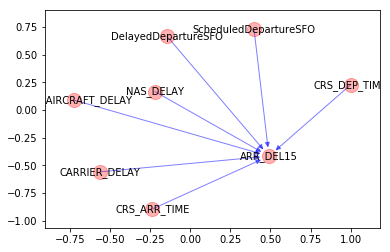

In [8]:
# update dataframe of edges and draw graph
flight_edges_df, bn = gf.update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
gf.draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

In [9]:
nas_delay_from =['CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'DelayedDepartureSFO']
gf.regression_model(train_df,nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     112.5
Date:                Sun, 06 May 2018   Prob (F-statistic):          3.74e-113
Time:                        20:34:51   Log-Likelihood:                -442.33
No. Observations:                 774   AIC:                             898.7
Df Residuals:                     767   BIC:                             931.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME           -0.0954      0.036     -2.674      0.008      -0.165      -0.025
TAXI_OUT                0.2543      0.018     14.482      0.000       0.220       0.289
TAXI_IN                 0.0897      0.028      3.252      0.001       0.036       0.144
CRS_ARR_TIME           -0.0600      0.032     -1.852      0.064      -0.124       0.004
CARRIER_DELAY           0.1987      0.038      5.218      0.000       0.124       0.273
LATE_AIRCRAFT_DELAY     0.1327      0.041      3.269      0.001       0.053       0.212
DelayedDepartureSFO    -0.0559      0.061     -0.924      0.356      -0.175       0.063
==============================================================================
Omnibus:                      197.428   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.926
Skew:                           0.547   Prob(JB):                     3.97e-16
Kurtosis:                       1.999   Cond. No.                         7.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
flight_edges_df, bn = gf.update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


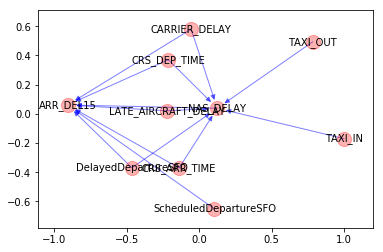

In [11]:
gf.draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [12]:
late_aircraft_from = ['CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'NAS_DELAY', 'ScheduledDepartureSFO']
gf.regression_model(train_df, late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.373
Model:                             OLS   Adj. R-squared:                  0.369
Method:                  Least Squares   F-statistic:                     91.68
Date:                 Sun, 06 May 2018   Prob (F-statistic):           1.11e-75
Time:                         20:34:51   Log-Likelihood:                -309.66
No. Observations:                  774   AIC:                             629.3
Df Residuals:                      769   BIC:                             652.6
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CRS_DEP_TIME              0.1486      0.023      6.485      0.000       0.104       0.194
DEP_DELAY                 0.1695      0.014     12.317      0.000       0.143       0.197
CRS_ARR_TIME              0.1164      0.020      5.809      0.000       0.077       0.156
NAS_DELAY                 0.0683      0.026      2.579      0.010       0.016       0.120
ScheduledDepartureSFO     0.0157      0.009      1.800      0.072      -0.001       0.033
==============================================================================
Omnibus:                       86.109   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.318
Skew:                           0.771   Prob(JB):                     6.64e-20
Kurtosis:                       2.400   Cond. No.                         4.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
flight_edges_df, bn = gf.update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [14]:
flight_edges_df, _ = gf.remove_edge('NAS_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = gf.remove_edge('LATE_AIRCRAFT_DELAY', 'NAS_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [15]:
carrier_delay_from = ['CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME', 'WEATHER_DELAY', 'NAS_DELAY']
gf.regression_model(train_df, carrier_delay_from, 'CARRIER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     105.3
Date:                Sun, 06 May 2018   Prob (F-statistic):           1.20e-96
Time:                        20:34:51   Log-Likelihood:                -326.46
No. Observations:                 774   AIC:                             664.9
Df Residuals:                     768   BIC:                             692.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
CRS_DEP_TIME      0.2312      0.029      7.984      0.000       0.174       0.288
DEP_DELAY         0.1939      0.014     13.393      0.000       0.166       0.222
TAXI_OUT         -0.0488      0.017     -2.875      0.004      -0.082      -0.015
CRS_ARR_TIME      0.1922      0.026      7.332      0.000       0.141       0.244
WEATHER_DELAY    -0.4922      0.186     -2.641      0.008      -0.858      -0.126
NAS_DELAY         0.1522      0.030      5.032      0.000       0.093       0.212
==============================================================================
Omnibus:                      135.650   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.982
Skew:                           0.333   Prob(JB):                     4.64e-10
Kurtosis:                       2.057   Cond. No.                         26.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
flight_edges_df, bn = gf.update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [17]:
# remove both edges
flight_edges_df, _ = gf.remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = gf.remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

### WEATHER_DELAY

In [18]:
weather_delay_from = ['DEP_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'DelayedArrivalPHL']
gf.regression_model(train_df, weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     4.796
Date:                Sun, 06 May 2018   Prob (F-statistic):           0.000795
Time:                        20:34:51   Log-Likelihood:                 948.93
No. Observations:                 774   AIC:                            -1890.
Df Residuals:                     770   BIC:                            -1871.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
DEP_DELAY             0.0079      0.003      2.626      0.009       0.002       0.014
CARRIER_DELAY        -0.0157      0.006     -2.421      0.016      -0.028      -0.003
NAS_DELAY             0.0126      0.005      2.730      0.006       0.004       0.022
DelayedArrivalPHL     0.0278      0.012      2.351      0.019       0.005       0.051
==============================================================================
Omnibus:                     1457.144   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1071139.490
Skew:                          13.347   Prob(JB):                         0.00
Kurtosis:                     183.280   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
flight_edges_df, bn = gf.update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'WEATHER_DELAY')]


In [20]:
flight_edges_df, bn = gf.remove_edge('CARRIER_DELAY', 'WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


### CRS Arrival Time

In [21]:
crs_arrival_from = ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'TAXI_OUT', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO']
gf.regression_model(train_df, crs_arrival_from, 'CRS_ARR_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_ARR_TIME   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     378.5
Date:                Sun, 06 May 2018   Prob (F-statistic):          7.19e-244
Time:                        20:34:51   Log-Likelihood:                -336.02
No. Observations:                 774   AIC:                             686.0
Df Residuals:                     767   BIC:                             718.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MONTH                     0.0366      0.004      9.830      0.000       0.029       0.044
DAY_OF_WEEK               0.0740      0.006     12.935      0.000       0.063       0.085
CRS_DEP_TIME             -0.7276      0.027    -26.471      0.000      -0.782      -0.674
TAXI_OUT                  0.1688      0.015     11.312      0.000       0.140       0.198
CARRIER_DELAY             0.1491      0.033      4.554      0.000       0.085       0.213
LATE_AIRCRAFT_DELAY       0.1694      0.035      4.865      0.000       0.101       0.238
ScheduledDepartureSFO     0.0199      0.009      2.175      0.030       0.002       0.038
==============================================================================
Omnibus:                       14.539   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.409
Skew:                           0.242   Prob(JB):                     0.000166
Kurtosis:                       3.553   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
flight_edges_df, bn = gf.update_flights_edges_df(crs_arrival_from, 'CRS_ARR_TIME', flight_edges_df)

[('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'NAS_DELAY')]


In [23]:
flight_edges_df, bn = gf.remove_edge('CARRIER_DELAY', 'CRS_ARR_TIME', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [24]:
flight_edges_df, bn = gf.remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### CRS Departure Time

In [25]:
crs_departure_from = ['MONTH', 'DAY_OF_WEEK', 'TAXI_OUT', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO'] 
gf.regression_model(train_df, crs_departure_from, 'CRS_DEP_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_DEP_TIME   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     274.1
Date:                Sun, 06 May 2018   Prob (F-statistic):          7.06e-204
Time:                        20:34:51   Log-Likelihood:                -296.03
No. Observations:                 774   AIC:                             606.1
Df Residuals:                     767   BIC:                             638.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MONTH                     0.0330      0.004      9.274      0.000       0.026       0.040
DAY_OF_WEEK               0.0627      0.006     11.295      0.000       0.052       0.074
TAXI_OUT                  0.1516      0.014     10.599      0.000       0.123       0.180
CRS_ARR_TIME             -0.6562      0.025    -26.471      0.000      -0.705      -0.607
CARRIER_DELAY             0.1867      0.031      6.062      0.000       0.126       0.247
LATE_AIRCRAFT_DELAY       0.2007      0.033      6.121      0.000       0.136       0.265
ScheduledDepartureSFO     0.0161      0.009      1.858      0.064      -0.001       0.033
==============================================================================
Omnibus:                       41.257   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.705
Skew:                           0.531   Prob(JB):                     2.65e-11
Kurtosis:                       3.617   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
flight_edges_df, bn = gf.update_flights_edges_df(crs_departure_from, 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'NAS_DELAY'), ('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_DEP_TIME')]


In [27]:
flight_edges_df, bn = gf.remove_edge('CARRIER_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME')]


In [28]:
flight_edges_df, bn = gf.remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [29]:
flight_edges_df, bn = gf.remove_edge('CRS_DEP_TIME', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [30]:
taxi_out_from = ['MONTH', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY']
gf.regression_model(train_df, taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     444.5
Date:                Sun, 06 May 2018   Prob (F-statistic):          5.76e-265
Time:                        20:34:51   Log-Likelihood:                -866.40
No. Observations:                 774   AIC:                             1747.
Df Residuals:                     767   BIC:                             1779.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.0631      0.007      8.689      0.000       0.049       0.077
CRS_DEP_TIME      0.7378      0.064     11.607      0.000       0.613       0.863
DEP_DELAY        -0.1237      0.032     -3.855      0.000      -0.187      -0.061
TAXI_IN          -0.1368      0.048     -2.868      0.004      -0.230      -0.043
CRS_ARR_TIME      0.7118      0.059     12.131      0.000       0.597       0.827
CARRIER_DELAY    -0.2295      0.072     -3.190      0.001      -0.371      -0.088
NAS_DELAY         0.7853      0.055     14.169      0.000       0.677       0.894
==============================================================================
Omnibus:                      104.909   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.803
Skew:                           0.782   Prob(JB):                     3.07e-48
Kurtosis:                       5.083   Cond. No.                         23.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
flight_edges_df, bn = gf.update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [32]:
flight_edges_df, bn = gf.remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY')]


In [33]:
flight_edges_df, bn = gf.remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'NAS_DELAY')]


In [34]:
flight_edges_df, bn = gf.remove_edge('TAXI_OUT', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'NAS_DELAY'), ('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_DEP_TIME')]


In [35]:
flight_edges_df, bn = gf.remove_edge('TAXI_OUT', 'CRS_DEP_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [36]:
taxi_in_from = ['CRS_ARR_TIME', 'NAS_DELAY', 'DelayedDepartureSFO']
gf.regression_model(train_df, taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     14.55
Date:                Sun, 06 May 2018   Prob (F-statistic):           3.17e-09
Time:                        20:34:51   Log-Likelihood:                -648.77
No. Observations:                 774   AIC:                             1304.
Df Residuals:                     771   BIC:                             1318.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_ARR_TIME            0.0840      0.030      2.835      0.005       0.026       0.142
NAS_DELAY               0.0946      0.038      2.491      0.013       0.020       0.169
DelayedDepartureSFO     0.2243      0.077      2.899      0.004       0.072       0.376
==============================================================================
Omnibus:                     1486.130   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2080393.914
Skew:                          13.558   Prob(JB):                         0.00
Kurtosis:                     255.533   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
flight_edges_df, bn = gf.update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [38]:
flight_edges_df, bn = gf.remove_edge('TAXI_IN', 'NAS_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [39]:
departure_delay_from = ['MONTH', 'DAY_OF_WEEK', 'TAXI_OUT', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY']
gf.regression_model(train_df, departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     73.18
Date:                Sun, 06 May 2018   Prob (F-statistic):           3.85e-72
Time:                        20:34:51   Log-Likelihood:                -910.55
No. Observations:                 774   AIC:                             1833.
Df Residuals:                     768   BIC:                             1861.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MONTH                  -0.0175      0.008     -2.247      0.025      -0.033      -0.002
DAY_OF_WEEK             0.0307      0.012      2.507      0.012       0.007       0.055
TAXI_OUT               -0.0761      0.032     -2.408      0.016      -0.138      -0.014
CRS_ARR_TIME           -0.1043      0.055     -1.905      0.057      -0.212       0.003
CARRIER_DELAY           0.8516      0.068     12.525      0.000       0.718       0.985
LATE_AIRCRAFT_DELAY     0.7408      0.072     10.241      0.000       0.599       0.883
==============================================================================
Omnibus:                       11.918   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               74.627
Skew:                           0.308   Prob(JB):                     6.24e-17
Kurtosis:                       1.609   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
flight_edges_df, bn = gf.update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'DEP_DELAY')]


In [41]:
flight_edges_df, bn = gf.remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


In [42]:
flight_edges_df, bn = gf.remove_edge('TAXI_OUT', 'DEP_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


In [43]:
flight_edges_df, bn = gf.remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'WEATHER_DELAY')]


In [44]:
flight_edges_df, bn = gf.remove_edge('DEP_DELAY', 'WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [45]:
delayed_SFO_from = ['TAXI_IN', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL']
gf.regression_model(train_df, delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.255
Model:                             OLS   Adj. R-squared:                  0.252
Method:                  Least Squares   F-statistic:                     87.98
Date:                 Sun, 06 May 2018   Prob (F-statistic):           5.77e-49
Time:                         20:34:51   Log-Likelihood:                 38.998
No. Observations:                  774   AIC:                            -72.00
Df Residuals:                      771   BIC:                            -58.04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TAXI_IN                   0.0392      0.015      2.697      0.007       0.011       0.068
ScheduledDepartureSFO     0.0679      0.005     12.471      0.000       0.057       0.079
ScheduledArrivalPHL       0.0251      0.008      3.004      0.003       0.009       0.042
==============================================================================
Omnibus:                      370.143   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1677.009
Skew:                           2.254   Prob(JB):                         0.00
Kurtosis:                       8.629   Cond. No.                         3.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
flight_edges_df, bn = gf.update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'NAS_DELAY')]


In [47]:
flight_edges_df, bn = gf.remove_edge('TAXI_IN', 'DelayedDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [48]:
delayed_PHL_from = ['TAXI_OUT', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL']
gf.regression_model(train_df,delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     289.9
Date:                Sun, 06 May 2018   Prob (F-statistic):          5.84e-126
Time:                        20:34:51   Log-Likelihood:                 370.75
No. Observations:                 774   AIC:                            -735.5
Df Residuals:                     771   BIC:                            -721.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TAXI_OUT                 -0.0178      0.004     -4.752      0.000      -0.025      -0.010
ScheduledDepartureSFO    -0.0110      0.004     -2.981      0.003      -0.018      -0.004
ScheduledArrivalPHL       0.1597      0.006     28.103      0.000       0.149       0.171
==============================================================================
Omnibus:                      292.963   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2454.382
Skew:                           1.475   Prob(JB):                         0.00
Kurtosis:                      11.210   Cond. No.                         2.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
flight_edges_df, bn = gf.update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'WEATHER_DELAY')]


In [50]:
flight_edges_df, bn = gf.remove_edge('DelayedArrivalPHL', 'WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Departures from SFO When Delayed Flight is scheduled to Depart

In [51]:
scheduled_SFO_from = ['MONTH',  'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DelayedDepartureSFO', 'DelayedArrivalPHL', 'ScheduledArrivalPHL']
gf.regression_model(train_df, scheduled_SFO_from, 'ScheduledDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ScheduledDepartureSFO   R-squared:                       0.414
Model:                               OLS   Adj. R-squared:                  0.409
Method:                    Least Squares   F-statistic:                     90.32
Date:                   Sun, 06 May 2018   Prob (F-statistic):           1.16e-85
Time:                           20:34:52   Log-Likelihood:                -1303.7
No. Observations:                    774   AIC:                             2619.
Df Residuals:                        768   BIC:                             2647.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MONTH                   0.0275      0.013      2.150      0.032       0.002       0.053
CRS_DEP_TIME            0.2652      0.105      2.519      0.012       0.059       0.472
CRS_ARR_TIME            0.3008      0.099      3.053      0.002       0.107       0.494
DelayedDepartureSFO     2.2402      0.187     11.977      0.000       1.873       2.607
DelayedArrivalPHL      -0.8714      0.312     -2.796      0.005      -1.483      -0.260
ScheduledArrivalPHL     0.4101      0.070      5.862      0.000       0.273       0.547
==============================================================================
Omnibus:                      228.339   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.516
Skew:                           1.710   Prob(JB):                    4.09e-103
Kurtosis:                       4.708   Cond. No.                         51.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
flight_edges_df, bn = gf.update_flights_edges_df(scheduled_SFO_from,'ScheduledDepartureSFO',flight_edges_df)

[('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [53]:
flight_edges_df, bn = gf.remove_edge('DelayedArrivalPHL', 'ScheduledDepartureSFO', flight_edges_df)

[('CRS_DEP_TIME', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [54]:
flight_edges_df, bn = gf.remove_edge('ScheduledDepartureSFO', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'CRS_DEP_TIME')]


In [55]:
flight_edges_df, bn = gf.remove_edge('ScheduledDepartureSFO', 'CRS_DEP_TIME', flight_edges_df)

[('ScheduledDepartureSFO', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'ScheduledDepartureSFO')]


In [56]:
flight_edges_df, bn = gf.remove_edge('DelayedDepartureSFO', 'ScheduledDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Arrivals at PHL When Delayed Flight is scheduled to Depart

In [57]:
scheduled_PHL_from = ['DAY_OF_WEEK', 'TAXI_OUT', 'DelayedDepartureSFO', 'ScheduledDepartureSFO', 'DelayedArrivalPHL']
gf.regression_model(train_df, scheduled_PHL_from, 'ScheduledArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ScheduledArrivalPHL   R-squared:                       0.642
Model:                             OLS   Adj. R-squared:                  0.639
Method:                  Least Squares   F-statistic:                     275.4
Date:                 Sun, 06 May 2018   Prob (F-statistic):          1.28e-168
Time:                         20:34:52   Log-Likelihood:                -774.67
No. Observations:                  774   AIC:                             1559.
Df Residuals:                      769   BIC:                             1583.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
DAY_OF_WEEK               0.0375      0.009      4.375      0.000       0.021       0.054
TAXI_OUT                  0.0793      0.022      3.547      0.000       0.035       0.123
DelayedDepartureSFO       0.1588      0.103      1.548      0.122      -0.043       0.360
ScheduledDepartureSFO     0.1108      0.018      6.312      0.000       0.076       0.145
DelayedArrivalPHL         3.1201      0.112     27.856      0.000       2.900       3.340
==============================================================================
Omnibus:                       93.247   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.276
Skew:                           0.575   Prob(JB):                     5.63e-64
Kurtosis:                       5.776   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
flight_edges_df, bn = gf.update_flights_edges_df(scheduled_PHL_from,'ScheduledArrivalPHL',flight_edges_df)

[('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'NAS_DELAY')]


In [59]:
flight_edges_df, bn = gf.remove_edge('DelayedArrivalPHL', 'ScheduledArrivalPHL', flight_edges_df)

[('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'NAS_DELAY')]


In [60]:
flight_edges_df, bn = gf.remove_edge('TAXI_OUT', 'ScheduledArrivalPHL', flight_edges_df)

[('DelayedDepartureSFO', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'DelayedDepartureSFO')]


In [61]:
flight_edges_df, bn = gf.remove_edge('DelayedDepartureSFO', 'ScheduledArrivalPHL', flight_edges_df)

[('ScheduledDepartureSFO', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO')]


In [62]:
flight_edges_df, bn = gf.remove_edge('ScheduledDepartureSFO', 'ScheduledArrivalPHL', flight_edges_df)

No cycle found! You may proceed.


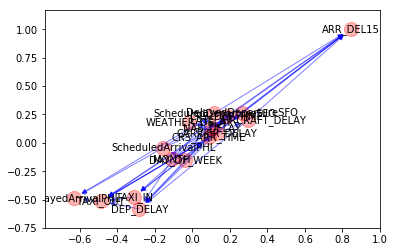

In [63]:
gf.draw_graph(flight_edges_df,'final_bn.png')

In [64]:
print('This graph is a DAG :', nx.is_directed_acyclic_graph(bn),'\nThis edge is a tree :', nx.is_tree(bn))

This graph is a DAG : True 
This edge is a tree : False


In [65]:
# nodes
nodes_li = list(set(list(flight_edges_df['from_node'])+list(flight_edges_df['to_node'])))
nodes_df = pd.DataFrame(nodes_li)
nodes_df.columns = ['nodes']
flight_edges_df.columns=['Source','Target']
# save as csv
flight_edges_df.to_csv('edges.csv',index=False)
nodes_df.to_csv('nodes.csv',index=False)
# numbers to print
print('There are', nodes_df.shape[0], 'nodes and', flight_edges_df.shape[0], 'edges in this graph.')

There are 16 nodes and 47 edges in this graph.
